# Loading STLs
We decided to use Python3D to load stls.
I used (BAIR Lab's?) jaxrl conda environment to run this notebook. I also built Python3D from source using github.
Here is the command I ran to build Python3D from source:

In [1]:
! pip install "git+https://github.com/facebookresearch/pytorch3d.git"

  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-p74lcq1u
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-p74lcq1u
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 055ab3a2e3e611dff66fa82f632e62a315f3b5e7
  Preparing metadata (setup.py) ... done


## Step 1: Import Pytorch3D
Imports are below:

In [59]:
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
! wget https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
trg_obj = 'dolphin.obj'
device = 'cuda:0'
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

--2024-12-05 00:14:59--  https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.51, 18.173.166.48, 18.173.166.74, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156763 (153K) [text/plain]
Saving to: ‘dolphin.obj.9’

dolphin.obj.9       100%[===================>] 153.09K  --.-KB/s    in 0.1s    

2024-12-05 00:15:00 (1.55 MB/s) - ‘dolphin.obj.9’ saved [156763/156763]



In [ ]:
from pytorch3d.ops import sample_points_from_meshes
import matplotlib.pyplot as plt
import numpy as np
points = sample_points_from_meshes(trg_mesh, 40000)
x, y, z = points.clone().detach().cpu().squeeze().unbind(1)  
x = [int((p + 1) * 1000) for p in x]
y = [int((p + 1) * 1000) for p in y]
z = [int((p + 1) * 1000) for p in z]
breakpoint()
y_flipped = np.negative(y) 
x_min = min(x)
x_max = max(x)
y_min = min(y_flipped)
y_max = max(y_flipped)
z_min = min(z)
z_max = max(z)
print(x_min)
print(x_max)
print(y_min)
print(y_max)
print(z_min)
print(z_max)
np.set_printoptions(threshold=np.inf)

height_map = np.zeros((2001,2001))

# for index_x, x_elem in enumerate(x):
#     for index_z, z_elem in enumerate(z):
#         height_map[x_elem][z_elem] = y[index_z]


for i in range(height_map.shape[0]):
    height_map[x[i]][y[i]] = z[i]
np.set_printoptions(threshold=100)
print(np.array(height_map))



def plot_pointcloud(points, title=""):
    # Sample points uniformly from the surface of the mesh.
    # points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

# plot_pointcloud(points, "Target mesh")8

x = np.arange(height_map.shape[0])  # x positions
y = np.arange(height_map.shape[1])  # y positions
X, Y = np.meshgrid(x, y)  # Create coordinate grids

# Z values correspond to the elements in the matrix
Z = height_map

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Flatten arrays to feed into bar3d
x_pos = X.ravel()
y_pos = Y.ravel()
z_pos = np.zeros_like(x_pos)  # All bars start at z=0
dx = dy = 1  # Width of each bar
dz = Z.ravel()  # Height of each bar

# Plot the 3D bar chart
ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, shade=True, cmap='viridis')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

619
1374
-1408
-172
1
1915


IndexError: index 1117 is out of bounds for axis 0 with size 1001

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   

AttributeError: 'list' object has no attribute 'ndim'

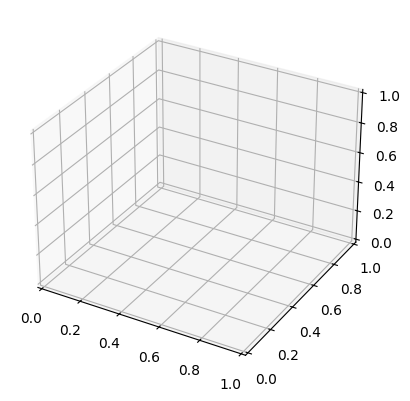

In [80]:
import numpy as np

# Set print options to prevent truncation
np.set_printoptions(threshold=np.inf)

# Example array
array = np.arange(100).reshape(10, 10)

print(height_map)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z)
plt.title('z as 3d height map')
plt.show()


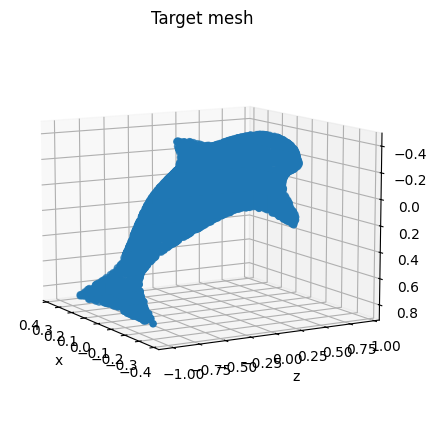

torch.Size([2562, 3])
tensor(-0.3814, device='cuda:0')
tensor(0.3757, device='cuda:0')
tensor(-1., device='cuda:0')
tensor(0.9219, device='cuda:0')
tensor(-0.4110, device='cuda:0')
tensor(0.8304, device='cuda:0')


In [51]:
import numpy as np
plot_pointcloud(points, "Target mesh")
print(trg_mesh.verts_packed().shape)
verts = trg_mesh.verts_packed()
verts = [(vert[0], vert[2], -vert[1]) for vert in verts]
verts_x = [vert[0] for vert in verts]
verts_y = [vert[1] for vert in verts]
verts_z = [vert[2] for vert in verts]
x_min = min(verts_x)
x_max = max(verts_x)
y_min = min(verts_y)
y_max = max(verts_y)
z_min = min(verts_z)
z_max = max(verts_z)
print(x_min)
print(x_max)
print(y_min)
print(y_max)
print(z_min)
print(z_max)

# height_map = np.zeros((len(range(x_min,x_max))))